# 人脸验证


人脸验证是通过参考照片确认个人身份的过程。例如，企业可以将每位员工的照片存储在数据库中。当员工出示工作证进入时，系统会将其照片与数据库中存储的照片进行比对，以验证其身份。


该任务面临以下挑战：
- 通常无法获取每位员工的大量照片用于训练。
- 最好避免每次有新员工加入时都需要重新训练模型。


为解决上述问题，我们将使用论文《判别式学习相似度度量及其在人脸验证中的应用》中描述的方法。该方法通过数据训练相似度度量。

该方法特别适用于包含大量类别的数据集（每个人脸视为一个类别），或在训练时并非所有类别都可用（如新员工加入）的情况。


首先，我们将分析论文中的一些理论要点，以理解该方法的工作原理，然后再进行实现。


## 论文理论分析


### 直观理解


该论文的主要思想是通过图像对（pairs）以对比的方式训练模型。有两种可能的情况：
- 两张图像来自同一类别。
- 两张图像来自不同类别。

目标是训练一个模型 $G_w$，将图像映射到潜在空间，使得欧几里得距离（或余弦距离）能够有效地区分不同元素。

更形式化地，我们希望：
$D_W(X_1,X_2) = \lVert G_W(X_1) - G_W(X_2) \rVert$ 在 $X_1$ 和 $X_2$ 属于同一类别时较小，属于不同类别时较大。


模型通过图像对进行训练，$G_W$ 的权重是共享的。

架构示意如下：

![siamese2](./images/siamese2.png)


### 对比损失函数


如何定义损失函数以实现上述目标？设 $Y$ 为图像对的标签。若 $Y=0$，表示两张图像来自同一类别；若 $Y=1$，则来自不同类别。

对比损失函数定义如下：
$L(Y,X_1,X_2)= (1-Y)\frac{1}{2}(D_W)^2 + (Y)\frac{1}{2}(\max(0,m-D_W))^2$

该函数看似复杂，但实际很简单。我们分析 $Y$ 的两种情况：
- 若 $Y=0$，则 $L(Y,X_1,X_2)=\frac{1}{2}(D_W)^2$，即前面定义的距离 $D_W$。
- 若 $Y=1$，则 $L(Y,X_1,X_2)=\frac{1}{2}(\max(0,m-D_W))^2$。这部分需要额外解释。直觉上，使用 $\frac{1}{D_W}$ 可以最大化距离，但实际中不可行，因为模型可能学习到一个极小的分离边界，导致泛化能力差。参数 $m$（边界）用于指定不同元素之间的最小分离距离，从而增强模型的鲁棒性并稳定训练。

**注意**：为何不直接最小化同类别图像对的 $D_W(X_1,X_2)$？这样会导致模型“崩溃”，学习到一个平凡解（如 $G_W$ 为常数函数），使损失始终为零。模型总会寻找最简单的解，因此需谨慎设计损失函数，避免模型找到平凡的捷径。


### 模型架构与训练


$G_W$ 可以是任意神经网络。论文建议使用卷积神经网络，因其在图像处理和抗几何扭曲（人脸验证中常见）方面表现优异。

我们不会严格复制论文中的架构，而是设计自己的架构，并使用比论文更大的数据集进行训练。

训练时，论文建议使用 50% 正样本对和 50% 负样本对。


## 实现


In [15]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

现在开始实现我们的模型！


### 数据集


我们使用 [LFW](https://vis-www.cs.umass.edu/lfw/) 数据集，其包含 5749 人的 13233 张图像，其中 1680 人至少有 2 张图像（用于构造正样本对）。我们使用 torchvision 中的 [LFWPairs](https://pytorch.org/vision/main/generated/torchvision.datasets.LFWPairs.html)，其已将图像按正负样本对等比例配对。


In [100]:
transform = T.Compose([
    T.ToTensor(),
    T.Resize((128,128)), # On réduit la taille des images pour accélérer l'entraînement
])
train_data=datasets.LFWPairs(root='./../data',download=False,split= 'train',transform=transform)
test_data=datasets.LFWPairs(root='./../data',download=False,split= 'test',transform=transform)

Nombre de paires pour le training:  2200
Nombre de paires pour le test: 1000
Taille image torch.Size([3, 128, 128])


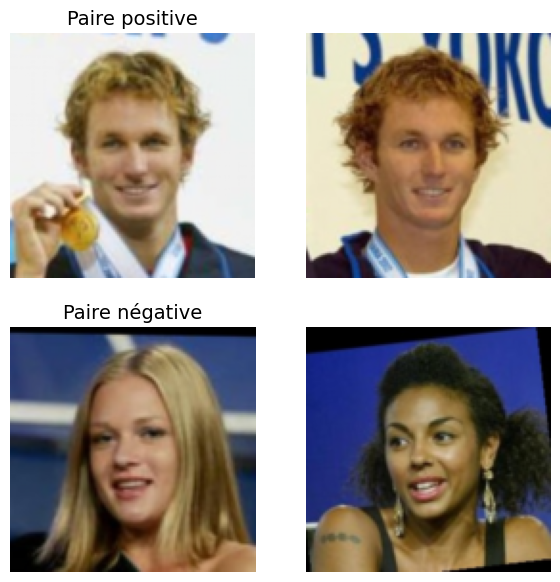

In [101]:
print('Nombre de paires pour le training: ',len(train_data))
print('Nombre de paires pour le test:',len(test_data))
print('Taille image',train_data[0][0].shape)

fig, axs = plt.subplots(2, 2, figsize=(7, 7))

axs[0, 0].imshow(train_data[0][0].permute(1, 2, 0))
axs[0, 0].axis('off')

axs[0, 1].imshow(train_data[0][1].permute(1, 2, 0))
axs[0, 1].axis('off')
for data in train_data:
  if data[2]==0:
    axs[1, 0].imshow(data[0].permute(1,2,0))
    axs[1, 0].axis('off')
    axs[1, 1].imshow(data[1].permute(1,2,0))
    axs[1, 1].axis('off')
    break
axs[0, 0].set_title("Paire positive", fontsize=14, ha='center')
axs[1, 0].set_title("Paire négative", fontsize=14, ha='center');


注意到在数据集中，$Y=1$ 表示正样本对，$Y=0$ 表示负样本对，这与论文中的符号相反。为保持清晰，我们将反转其定义。


In [102]:
# On ne peut pas modifier les données directement, on doit les transformer en listes
# Pour les données de training
train_data_list = [list(data) for data in train_data]
for data in train_data_list:
    data[2] = 1 - data[2]
train_data = [tuple(data) for data in train_data_list]

# Pour les données de test
test_data_list = [list(data) for data in test_data]
for data in test_data_list:
    data[2] = 1 - data[2]
test_data = [tuple(data) for data in test_data_list]

现在我们可以创建数据加载器：


In [103]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

### 对比损失函数


现在定义我们的损失函数。我们直接使用之前介绍的公式。对于 $D_W$，我们采用欧几里得距离：
$D_W(X_1,X_2) = \lVert X_1 - X_2 \rVert_2 = \sqrt{\sum_{i=1}^{n} (X_{1,i} - X_{2,i})^2}$


In [104]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # Distance euclidienne entre les deux sorties du réseau
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
        
        # Calcul du loss contrastif
        loss_contrastive = torch.mean(
            (1 - label) * torch.pow(euclidean_distance, 2) +
            (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )
        
        return loss_contrastive

### 构建我们的模型


对于该任务，我们将构建一个经典的小型卷积神经网络。模型的目标是将数据投影到一个空间，使欧几里得距离具有实际意义。


In [142]:
class SiameseNetwork(torch.nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Extraction des features pertinentes
        self.conv_net = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        
        # Projection des features dans un espace de dimension réduite
        self.linear=nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Linear(256, 32), 
            )
    
    def forward(self, x1, x2):
        x1 = self.conv_net(x1)
        x2 = self.conv_net(x2)
        x1 = x1.view(x1.size(0), -1)
        x2 = x2.view(x2.size(0), -1)
        x1=self.linear(x1)
        x2=self.linear(x2)
        return x1,x2

### 模型训练


定义训练超参数：


In [134]:
epochs = 30
lr = 0.001
margin = 1.0
model = SiameseNetwork().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion=ContrastiveLoss(margin=margin)

In [135]:
for epoch in range(epochs):
  loss_train = 0
  for x1, x2, label in train_loader:
    x1, x2, label = x1.to(device), x2.to(device), label.to(device)
    optimizer.zero_grad()
    out1, out2 = model(x1, x2)
    loss = criterion(out1, out2, label)
    loss_train+=loss.item()
    loss.backward()
    optimizer.step()
  print(f"Epoch {epoch+1}/{epochs} Loss: {loss_train/len(train_loader)}")

Epoch 1/30 Loss: 0.4855058027998261
Epoch 2/30 Loss: 0.47506297098985617
Epoch 3/30 Loss: 0.44379603841166565
Epoch 4/30 Loss: 0.36472982092612033
Epoch 5/30 Loss: 0.31656959955243097
Epoch 6/30 Loss: 0.3091158025722573
Epoch 7/30 Loss: 0.2988005231903947
Epoch 8/30 Loss: 0.2873344306928524
Epoch 9/30 Loss: 0.28030256138763565
Epoch 10/30 Loss: 0.27428370077108993
Epoch 11/30 Loss: 0.27216234900381253
Epoch 12/30 Loss: 0.2714559338662935
Epoch 13/30 Loss: 0.2713507852260617
Epoch 14/30 Loss: 0.27069854628348694
Epoch 15/30 Loss: 0.26960040553324466
Epoch 16/30 Loss: 0.26909896256267163
Epoch 17/30 Loss: 0.2681442526155624
Epoch 18/30 Loss: 0.26780268636302673
Epoch 19/30 Loss: 0.2663887916267782
Epoch 20/30 Loss: 0.26515361407528754
Epoch 21/30 Loss: 0.26577359880658163
Epoch 22/30 Loss: 0.266544328543587
Epoch 23/30 Loss: 0.2644324919235879
Epoch 24/30 Loss: 0.26508791971465817
Epoch 25/30 Loss: 0.26529018699690915
Epoch 26/30 Loss: 0.26407808313767117
Epoch 27/30 Loss: 0.264637937796

### 模型评估


训练完成后，我们需要评估模型。但如何评估？这与我们常见的模型类型不同。

我们可以使用测试数据集，计算其中每个样本对的距离，从而为每个测试样本获得一个相似度得分。

**ROC 曲线**：ROC 曲线（Receiver Operating Characteristic）用于展示二分类模型（如我们的正负样本判断）在不同决策阈值下的性能。ROC 曲线包含以下要素：
- **横轴**：假阳性率（误报率），即被错误分类为正样本的负样本数占负样本总数的比例。
- **纵轴**：真阳性率（召回率或灵敏度），即被正确分类为正样本的正样本数占正样本总数的比例。

曲线上的每个点对应一个不同的决策阈值。

![roc](./images/roc.png)

（图片来源：[博客文章](https://sefiks.com/2020/12/10/a-gentle-introduction-to-roc-curve-and-auc/)）


为评估模型质量，我们可以计算 ROC 曲线下的面积（AUROC）。对于随机分类器，AUROC 为 0.5；对于完美分类器，AUROC 为 1。

我们可以计算我们的模型的 AUROC：


In [139]:
from sklearn.metrics import roc_curve, auc

model.eval()
labels = []
distances = []
with torch.no_grad():
    for x1, x2, label in test_loader:
        x1, x2, label = x1.to(device), x2.to(device), label.to(device)
        out1, out2 = model(x1, x2)
        dist = torch.nn.functional.pairwise_distance(out1, out2)
        distances.extend(dist.cpu().numpy())
        labels.extend(label.cpu().numpy())
        
fpr, tpr, thresholds = roc_curve(labels, distances)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC: {roc_auc}")


ROC AUC: 0.6163399999999999


我们得到的 AUROC 约为 0.62，表现并不理想。我们可以绘制曲线以查看其形状。


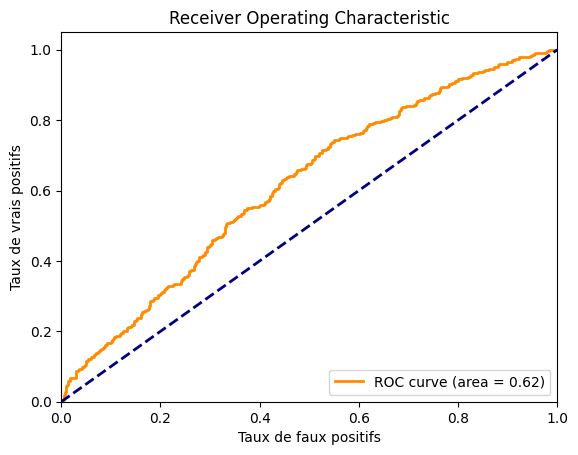

In [141]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

可以看出模型性能不佳。数据集可能相对于模型规模过于复杂。您可以通过调整架构和训练参数来尝试提升模型性能。


## 三元组损失


### 人脸识别


在人脸处理领域，主要有两类任务：人脸验证和人脸识别。

以企业员工为例，两者的区别如下：
- **人脸验证**：员工持工作证进入大楼时，系统验证其人脸是否与工作证对应的员工一致。
- **人脸识别**：员工未持工作证时，系统能从所有员工数据库中识别出其身份并允许进入。

显然，人脸识别是更复杂的任务，无论是难度还是处理时间（不能让员工在门口等待一小时，只为将其照片与数据库中的数百张照片比对）。


### FaceNet


对于人脸识别任务，论文《[FaceNet: A Unified Embedding for Face Recognition and Clustering](https://arxiv.org/pdf/1503.03832)》提出了一种类似对比损失的新型损失函数——三元组损失（Triplet Loss），我们将简要介绍。


三元组损失的目标与对比损失类似：学习一种表示，使相似样本的特征向量（embeddings）在潜在空间中靠近，而不同样本的特征向量远离。

与基于样本对的对比损失不同，三元组损失基于样本三元组！每个样本在三元组中有特定角色：
- **Anchor (A)**：参考样本，用于学习其表示。
- **Positive (P)**：与 Anchor 相似的样本（如同一个人）。
- **Negative (N)**：与 Anchor 不同的样本（如不同的人）。

损失函数定义为：
$L_{\text{triplet}} = \max\left( d(A, P) - d(A, N) + \alpha, 0 \right)$，其中 $d$ 为距离，$\alpha$ 为边界（margin）。

该损失函数通过最小化 $A$ 与 $P$ 的距离，同时最大化 $A$ 与 $N$ 的距离，实现目标。

![tripletloss](./images/tripletloss.png)

（图片来源于原论文）

虽然看似与对比损失重叠，但三元组损失在区分高度相似的类别（如人脸识别）时表现更佳。目前，在人脸处理任务中，三元组损失已成为优先选择，优于对比损失。